In [1]:
# import some keras and basic module 

from __future__ import print_function 
import tensorflow.keras as keras
import tensorflow as tf

# data set cifar 10 
from tensorflow.keras.datasets import cifar10 

# basic preprocesssing for image data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct neural network 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 

from tensorflow.keras.layers import Conv2D, MaxPooling2D

import os 

import numpy as np 

import matplotlib.pyplot as plt

config = tf.ConfigProto()
tf.enable_eager_execution(config=config)


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:

## basic parameters 
batch_size = 32 
num_classes = 10 
num_epochs = 200 
is_data_augmentation = True  
model_dir = 'models'
model_filename = 'keras_cifar10_model_LeNet5_5_data_augumentation.h1'



In [3]:
#read data and split data into train and test set

(train_set,train_label),(test_set,test_label) = cifar10.load_data() 

print('the shape of training data set is: ',train_set.shape) 

# print number of train and test samples 

# train samples 50000
#print(train_set.shape[0] , 'train samples') 

# test samples 10000
#print(test_set.shape[0] , 'test samples') 

#print(train_label)

the shape of training data set is:  (50000, 32, 32, 3)


In [4]:
# Convert class label to binary vector 
train_label = keras.utils.to_categorical(train_label,num_classes)
test_label  = keras.utils.to_categorical(test_label,num_classes) 
print(train_label.shape)
print(test_label.shape)

(50000, 10)
(10000, 10)


the code input for Conv2D 
```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

In [5]:
# construct the model 

cnn_model = Sequential() 


# convolutional layer stride 1 no padding nfilters = 6 input_shape = 32*32*3
# acitvation = softmax
cnn_model.add(Conv2D(6,(5,5),padding='valid',input_shape=train_set.shape[1:], ))
cnn_model.add(Activation('relu'))

# max-pooling layer window size 2*2
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

# convolutional layer stride 1 no padding nfilters = 6 input_shape = 14*14*6
# activation = softmax
cnn_model.add(Conv2D(16,(5,5),padding ='valid'))
cnn_model.add(Activation('relu'))

# max-pooling layer window size 2*2
cnn_model.add(MaxPooling2D(pool_size =(2,2) ))

# flatten 2d to 1d 
cnn_model.add(Flatten())


# full connected layer nfilters = 120 

cnn_model.add(Dense(120,activation = 'relu' )) 

# full connected layer nfilters = 84 
cnn_model.add(Dense(84, activation = 'relu'))

# last full connected layer nfilters = 10 
cnn_model.add(Dense(10 , activation = 'softmax'))



In [6]:


# initialization of optimizer 
opt = keras.optimizers.RMSprop(learning_rate = 0.0001,decay = 1e-6)

# train the model by optimizer
cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

train_set = train_set.astype('float32')
test_set = test_set.astype('float32') 

train_set /= 255 
test_set /= 255 

if not is_data_augmentation:
    print('Not using data augmentation.')
    cnn_history = cnn_model.fit(train_set, train_label,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(test_set, test_label),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # zca_whitening = True
    # rotation_range = 20 
    # shear_range = 0.2 
    # zoom_range = 0.2 
    data_transform_parameters = {
                                "featurewise_center":True,
                                "featurewise_std_normalization" : True,
                                "rotation_range": 20,
                                "width_shift_range":0.2,
                                "height_shift_range":0.2,
                                "horizontal_flip":True
                                }
    
    
    # This will do preprocessing and realtime data augmentation:
    augument_data_set_generator = ImageDataGenerator(data_transform_parameters)
    
    # random_parameter= augument_data_set_generator.get_random_transform((32,32))
     
    # print(random_parameter)
        
    # compute quantities required for feature-wise normalization 
    # (std, mean ,and pricipal components if ZCA whitening is applied)
    #augument_data_set_generator.fit(train_set) 
    augument_train_set = augument_data_set_generator.apply_transform(train_set,data_transform_parameters)
    print(augument_train_set.shape)
    # Fit the model on the batches generated by augument_data_set.flow() 
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only use the first GPU
      try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
      except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
   
    with tf.device('/device:GPU:0'):
        cnn_history = cnn_model.fit(augument_train_set, train_label,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  validation_data=(test_set, test_label),
                  shuffle=True)
        # here's a more "manual" example

                

# save model and weights 
if not os.path.isdir(model_dir): 
    os.makedirs(model_dir) 
model_path = os.path.join(model_dir,model_filename)
cnn_model.save(model_path)
print("CNN Model saved at %s " % model_path)

# Score trained model 

test_loss_value, test_metric_value = cnn_model.evaluate(test_set,test_label,verbose =1 )
train_loss_value, train_metric_value = cnn_model.evaluate(train_set,train_label,verbose =1)


print("Train loss: ", train_loss_value) 
print("Trian metric: ", train_metric_value)

print("Test loss: ", test_loss_value)
print("Test accuracy:", test_metric_value)
print(cnn_history.history)


Using real-time data augmentation.
(50000, 32, 32, 3)
1 Physical GPUs, 1 Logical GPU
Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
50000/50000 [==============================] - 9s 174us/sample - loss: 1.9893 - acc: 0.2674 - val_loss: 1.7670 - val_acc: 0.3610
Epoch 2/200
50000/50000 [==============================] - 7s 138us/sample - loss: 1.6778 - acc: 0.3871 - val_loss: 1.6361 - val_acc: 0.4042
Epoch 3/200
50000/50000 [==============================] - 7s 145us/sample - loss: 1.5786 - acc: 0.4262 - val_loss: 1.6304 - val_acc: 0.4133
Epoch 4/200
50000/50000 [==============================] - 7s 150us/sample - loss: 1.5111 - acc: 0.4545 - val_loss: 1.5451 - val_acc: 0.4472
Epoch 5/200
50000/50000 [==============================] - 7s 144us/sample - loss: 1.4627 - acc: 0.4742 - val_loss: 1.4591 - val_acc: 0.4758
Epoch 6/200
50000/50000 [==============================] - 7s 145u

Epoch 113/200
50000/50000 [==============================] - 7s 143us/sample - loss: 0.6640 - acc: 0.7699 - val_loss: 1.1271 - val_acc: 0.6437
Epoch 114/200
50000/50000 [==============================] - 7s 140us/sample - loss: 0.6602 - acc: 0.7700 - val_loss: 1.1222 - val_acc: 0.6456
Epoch 115/200
50000/50000 [==============================] - 7s 135us/sample - loss: 0.6578 - acc: 0.7718 - val_loss: 1.1206 - val_acc: 0.6475
Epoch 116/200
50000/50000 [==============================] - 7s 140us/sample - loss: 0.6547 - acc: 0.7717 - val_loss: 1.1174 - val_acc: 0.6431
Epoch 117/200
50000/50000 [==============================] - 7s 143us/sample - loss: 0.6516 - acc: 0.7710 - val_loss: 1.1283 - val_acc: 0.6452
Epoch 118/200
50000/50000 [==============================] - 7s 140us/sample - loss: 0.6476 - acc: 0.7732 - val_loss: 1.1433 - val_acc: 0.6389
Epoch 119/200
50000/50000 [==============================] - 7s 143us/sample - loss: 0.6457 - acc: 0.7764 - val_loss: 1.1299 - val_acc: 0.6392

Text(0.5, 1.0, 'test loss and test accuracy')

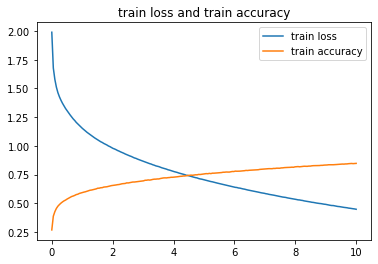

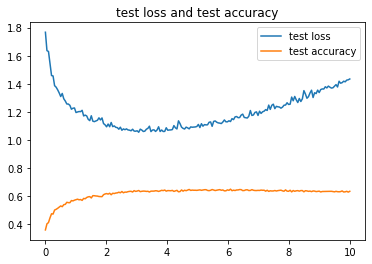

In [8]:

# get history data
epoth_x = np.linspace(0, 10, num_epochs, endpoint=True)
train_loss = cnn_history.history['loss']
train_accuracy = cnn_history.history['acc']
test_loss = cnn_history.history['val_loss']
test_accuracy = cnn_history.history['val_acc']

# plot train loss and accuracy
plt.figure() 
plt.plot(epoth_x, train_loss,label = 'train loss')
plt.plot(epoth_x,train_accuracy,label = 'train accuracy')
plt.title("train loss and train accuracy")
plt.legend()


# plot test loss and accuracy
plt.figure() 
plt.plot(epoth_x, test_loss, label = 'test loss')
plt.plot(epoth_x,test_accuracy, label = 'test accuracy')
plt.legend()
plt.title("test loss and test accuracy")